In [11]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.cross_decomposition import CCA
import pandas as pd
import scipy.io

A

In [12]:
fs = 250       #Frequência de amostragem
#Vai do instante 0.64 até 3.64
#750 amostras
start_time = 0.64  
window_duration = 3.0  
start_sample = int(start_time * fs)  
end_sample = start_sample + int(window_duration * fs) 
bloco = 1                   
alvo = 21                
eletrodos_alvo = ['PZ', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2']

In [13]:
channels_df = pd.read_csv('64-channels.loc', delim_whitespace=True, header=None, 
                          names=["idx", "x", "y", "label"])

In [14]:
idx_eletrodos = []
for eletrodo in eletrodos_alvo:
    idx = int(channels_df[channels_df['label'] == eletrodo]['idx'].iloc[0])
    idx_eletrodos.append(idx)

In [15]:
mat = scipy.io.loadmat('S3.mat')
data = mat['data']

In [16]:
#Aplica o filtro de 3Hz e o janelamento

signals = np.zeros((len(idx_eletrodos), end_sample - start_sample))
for i, idx in enumerate(idx_eletrodos):
    signal = data[idx, start_sample:end_sample, alvo, bloco]  
    b, a = butter(4, 3 / (fs / 2), btype='highpass') 
    signals[i] = filtfilt(b, a, signal)

In [17]:
eeg_data = signals.T

In [18]:
#Extrai a freq de estímulo

freq_phase = scipy.io.loadmat('Freq_Phase.mat')
freqs_estimulo = freq_phase['freqs'] 
f_alvo = freqs_estimulo[0, alvo] 

In [19]:
rho_values = np.zeros(40) 

#Controi Y e aplica cca
for m in range(40):
    f = freqs_estimulo[0, m]
    
   
    t = np.linspace(0, (end_sample - start_sample)/fs, end_sample - start_sample, endpoint=False)
    Yf_sin = np.sin(2 * np.pi * f * t)
    Yf_cos = np.cos(2 * np.pi * f * t)
    Y2f_sin = np.sin(2 * np.pi * 2 * f * t)
    Y2f_cos = np.cos(2 * np.pi * 2 * f * t)
    
    
    Y_ref = np.vstack([Yf_sin, Yf_cos, Y2f_sin, Y2f_cos]).T
    
    cca = CCA(n_components=1)
    X_cca, Y_cca = cca.fit_transform(eeg_data, Y_ref)
    rho = np.corrcoef(X_cca.flatten(), Y_cca.flatten())[0, 1]
    rho_values[m] = rho

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


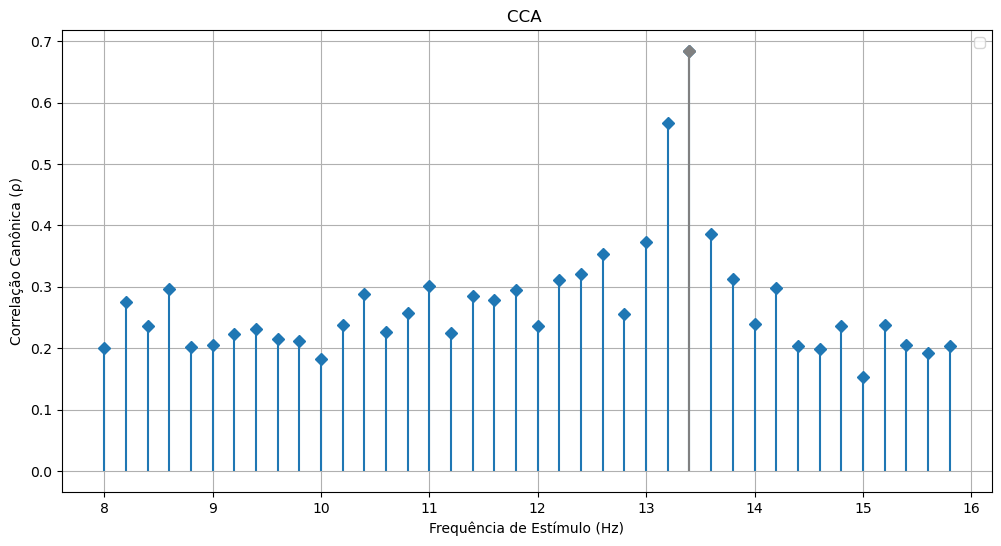

In [20]:
idx_max = np.argmax(rho_values)
max_rho = rho_values[idx_max]
f_max = freqs_estimulo[0, idx_max]


plt.figure(figsize=(12, 6))
plt.stem(freqs_estimulo[0], rho_values, basefmt=" ", use_line_collection=True, markerfmt='D')
if f_max != f_alvo:
    markerline, stemlines, baseline = plt.stem(f_max, max_rho, basefmt=" ", use_line_collection=True, linefmt='red', markerfmt='D')
    plt.stem(f_alvo, rho_values[alvo], basefmt=" ", use_line_collection=True, linefmt='purple', markerfmt='D')
    markerline.set_markerfacecolor('red')
    markerline.set_markeredgecolor('red')
else:
    markerline, stemlines, baseline = plt.stem(f_max, max_rho, basefmt=" ", use_line_collection=True, linefmt='gray', markerfmt='D')
    markerline.set_markerfacecolor('gray')
    markerline.set_markeredgecolor('gray')
plt.xlabel('Frequência de Estímulo (Hz)')
plt.ylabel('Correlação Canônica (ρ)')
plt.title('CCA ')
plt.grid(True)
plt.legend()
plt.show()


B e C

In [45]:
fs = 250 
start_time = 0.64  
bloco = 2           
eletrodos_alvo = ['PZ', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2'] 

In [46]:
channels_df = pd.read_csv('64-channels.loc', delim_whitespace=True, header=None, 
                          names=["idx", "x", "y", "label"])

In [47]:
idx_eletrodos = []
for eletrodo in eletrodos_alvo:
    idx = int(channels_df[channels_df['label'] == eletrodo]['idx'].iloc[0])
    idx_eletrodos.append(idx)

In [48]:
mat = scipy.io.loadmat('S3.mat')
data = mat['data']

In [49]:
freq_phase = scipy.io.loadmat('Freq_Phase.mat')
freqs_estimulo = freq_phase['freqs'] 

In [50]:
duracoes = np.arange(0.5, 5.25, 0.25)  #Janelas de amostragem (step de 0.25)
harmonicas_configs = [1, 2, 3, 4, 5, 6]  #Número de harmônicas
num_trials = 240  #Total de trials
num_classes = 40 

In [51]:
def gerar_sinais_referencia(freq, duracao, num_harmonicas, fs, start_sample, end_sample):
    #t = np.linspace(0, duracao, int(duracao * fs), endpoint=False)
    t = np.linspace(0, (end_sample - start_sample)/fs, end_sample - start_sample, endpoint=False)
    
    sinais = []
    for h in range(1, num_harmonicas + 1):
        sinais.append(np.sin(2 * np.pi * h * freq * t))
        sinais.append(np.cos(2 * np.pi * h * freq * t))
    
    return np.vstack(sinais).T

In [52]:
def aplicar_cca_classificacao(eeg_data, freqs_estimulo, duracao, num_harmonicas, fs, start_sample, end_sample):
    num_amostras = int(duracao * fs)
    rho_values = np.zeros(num_classes)
    
    for m in range(num_classes):
        f = freqs_estimulo[0, m]
        
        Y_ref = gerar_sinais_referencia(f, duracao, num_harmonicas, fs, start_sample, end_sample)
        
        cca = CCA(n_components=1)
        try:
            X_cca, Y_cca = cca.fit_transform(eeg_data, Y_ref)
            rho = np.corrcoef(X_cca.flatten(), Y_cca.flatten())[0, 1]
            rho_values[m] = abs(rho) 
        except:
            rho_values[m] = 0
    
    return rho_values

In [53]:
def calcular_acuracia_itr(duracoes, harmonicas_configs):
    resultados = {}
    
    for num_harmonicas in harmonicas_configs:
        acuracias = []
        itrs = []
        
        print(f"{num_harmonicas} harmônica(s)")
        
        for duracao in duracoes:
            print(f"  Duração: {duracao:.2f}s")
            
            start_sample = int(start_time * fs)
            end_sample = start_sample + int(duracao * fs)
            
            acertos = 0
            #Testa todos os alvos e blocos disponíveis (6*240)
            for bloco_teste in range(min(6, data.shape[3])):
                for alvo in range(num_classes):
                    try:
                        #Extrai e filtra sinais
                        signals = np.zeros((len(idx_eletrodos), end_sample - start_sample))
                        for i, idx in enumerate(idx_eletrodos):
                            signal = data[idx, start_sample:end_sample, alvo, bloco_teste]
                            b, a = butter(4, 3 / (fs / 2), btype='highpass')
                            #b, a = butter(4, [7 / (fs / 2), 70 / (fs / 2)], btype='bandpass')
                            signals[i] = filtfilt(b, a, signal)
                            #signals[i] = signal
                        
                        #Média dos canais
                        eeg_data = signals.T
                        
                        rho_values = aplicar_cca_classificacao(eeg_data, freqs_estimulo, 
                                                             duracao, num_harmonicas, fs, start_sample, end_sample)
                        
                        predicao = np.argmax(rho_values)
                        
                        if predicao == alvo:
                            acertos += 1
                        
                    except:
                        continue
            
            acuracia = acertos / num_trials
            print(acertos)
            print(acuracia)
            
            p = max(min(acuracia, 0.999), 0.001)
            itr = (np.log2(num_classes) + p * np.log2(p) + 
                       (1-p) * np.log2((1-p)/(num_classes-1))) * (60/(0.55+duracao))
            
            print(itr)
            
            acuracias.append(acuracia*100)
            itrs.append(max(itr, 0)) 
        
        resultados[num_harmonicas] = {
            'acuracias': np.array(acuracias),
            'itrs': np.array(itrs)
        }
        
    
    return resultados

1 harmônica(s)
  Duração: 0.50s
18
0.075
2.7782570464734944
  Duração: 0.75s
29
0.12083333333333333
6.619713331327691
  Duração: 1.00s
39
0.1625
9.876650048097256
  Duração: 1.25s
62
0.25833333333333336
19.256684281312147
  Duração: 1.50s
90
0.375
31.14490844410222
  Duração: 1.75s
135
0.5625
52.71822302208604
  Duração: 2.00s
167
0.6958333333333333
66.54023995013593
  Duração: 2.25s
191
0.7958333333333333
75.27089103742372
  Duração: 2.50s
217
0.9041666666666667
85.7658435428569
  Duração: 2.75s
224
0.9333333333333333
83.93106567166895
  Duração: 3.00s
232
0.9666666666666667
83.40685724969165
  Duração: 3.25s
234
0.975
79.28103328293372
  Duração: 3.50s
236
0.9833333333333333
75.72661423462148
  Duração: 3.75s
235
0.9791666666666666
70.68448323545482
  Duração: 4.00s
238
0.9916666666666667
68.68158368442246
  Duração: 4.25s
238
0.9916666666666667
65.10441786752546
  Duração: 4.50s
239
0.9958333333333333
62.50647350076531
  Duração: 4.75s
240
1.0
60.059263414313655
  Duração: 5.00s
240

/home/cesar/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


236
0.9833333333333333
100.55501234433343
  Duração: 2.75s
236
0.9833333333333333
92.93720837885364
  Duração: 3.00s
237
0.9875
87.19294582122444
  Duração: 3.25s
237
0.9875
81.4565678066702
  Duração: 3.50s
237
0.9875
76.42838460872758
  Duração: 3.75s
237
0.9875
71.98487387566202
  Duração: 4.00s
238
0.9916666666666667
68.68158368442246
  Duração: 4.25s
238
0.9916666666666667
65.10441786752546
  Duração: 4.50s
239
0.9958333333333333
62.50647350076531
  Duração: 4.75s
240
1.0
60.059263414313655
  Duração: 5.00s


/home/cesar/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


240
1.0
57.35389118844366
3 harmônica(s)
  Duração: 0.50s
56
0.23333333333333334
27.771968358567886
  Duração: 0.75s
111
0.4625
68.54242129002965
  Duração: 1.00s
169
0.7041666666666667
111.56872782326202
  Duração: 1.25s
190
0.7916666666666666
116.08392554936478
  Duração: 1.50s
212
0.8833333333333333
122.50522096143791
  Duração: 1.75s
227
0.9458333333333333
123.43815151441144
  Duração: 2.00s
231
0.9625
115.12977778796595
  Duração: 2.25s
233
0.9708333333333333
106.66232504051226
  Duração: 2.50s


/home/cesar/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


236
0.9833333333333333
100.55501234433343
  Duração: 2.75s
236
0.9833333333333333
92.93720837885364
  Duração: 3.00s
237
0.9875
87.19294582122444
  Duração: 3.25s
237
0.9875
81.4565678066702
  Duração: 3.50s
237
0.9875
76.42838460872758
  Duração: 3.75s
237
0.9875
71.98487387566202
  Duração: 4.00s
238
0.9916666666666667
68.68158368442246
  Duração: 4.25s
238
0.9916666666666667
65.10441786752546
  Duração: 4.50s
239
0.9958333333333333
62.50647350076531
  Duração: 4.75s
240
1.0
60.059263414313655
  Duração: 5.00s
240
1.0
57.35389118844366
4 harmônica(s)
  Duração: 0.50s


/home/cesar/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


68
0.2833333333333333
38.52019742771426
  Duração: 0.75s
120
0.5
77.50278394413408
  Duração: 1.00s
178
0.7416666666666667
121.2507716473336
  Duração: 1.25s
204
0.85
130.6425819113875
  Duração: 1.50s
214
0.8916666666666667
124.52120852414855
  Duração: 1.75s
230
0.9583333333333334
126.56923590265002
  Duração: 2.00s
231
0.9625
115.12977778796595
  Duração: 2.25s


/home/cesar/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


233
0.9708333333333333
106.66232504051226
  Duração: 2.50s
237
0.9875
101.48687136568745
  Duração: 2.75s
236
0.9833333333333333
92.93720837885364
  Duração: 3.00s
237
0.9875
87.19294582122444
  Duração: 3.25s
237
0.9875
81.4565678066702
  Duração: 3.50s
237
0.9875
76.42838460872758
  Duração: 3.75s
237
0.9875
71.98487387566202
  Duração: 4.00s
238
0.9916666666666667
68.68158368442246
  Duração: 4.25s
238
0.9916666666666667
65.10441786752546
  Duração: 4.50s
239
0.9958333333333333
62.50647350076531
  Duração: 4.75s
240
1.0
60.059263414313655
  Duração: 5.00s
240
1.0
57.35389118844366
5 harmônica(s)
  Duração: 0.50s
71
0.29583333333333334
41.370641679934344
  Duração: 0.75s
129
0.5375
86.83804435532201
  Duração: 1.00s
183
0.7625
126.80465718792652
  Duração: 1.25s
206
0.8583333333333333
132.8191902205362
  Duração: 1.50s
215
0.8958333333333334
125.5404648489596
  Duração: 1.75s
230
0.9583333333333334
126.56923590265002
  Duração: 2.00s
231
0.9625
115.12977778796595
  Duração: 2.25s
234

/home/cesar/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/cesar/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


238
0.9916666666666667
65.10441786752546
  Duração: 4.50s
239
0.9958333333333333
62.50647350076531
  Duração: 4.75s
240
1.0
60.059263414313655
  Duração: 5.00s
240
1.0
57.35389118844366
6 harmônica(s)
  Duração: 0.50s
76
0.31666666666666665
46.25810850299811
  Duração: 0.75s
129
0.5375
86.83804435532201
  Duração: 1.00s
183
0.7625
126.80465718792652
  Duração: 1.25s
206
0.8583333333333333
132.8191902205362
  Duração: 1.50s
215
0.8958333333333334
125.5404648489596
  Duração: 1.75s
230
0.9583333333333334
126.56923590265002
  Duração: 2.00s
231
0.9625
115.12977778796595
  Duração: 2.25s
234
0.975
107.59568802683863
  Duração: 2.50s
237
0.9875
101.48687136568745
  Duração: 2.75s
237
0.9875
93.79847201980203
  Duração: 3.00s
237
0.9875
87.19294582122444
  Duração: 3.25s
237
0.9875
81.4565678066702
  Duração: 3.50s
237
0.9875
76.42838460872758
  Duração: 3.75s


/home/cesar/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


237
0.9875
71.98487387566202
  Duração: 4.00s
238
0.9916666666666667
68.68158368442246
  Duração: 4.25s
238
0.9916666666666667
65.10441786752546
  Duração: 4.50s
239
0.9958333333333333
62.50647350076531
  Duração: 4.75s
240
1.0
60.059263414313655
  Duração: 5.00s
240
1.0
57.35389118844366


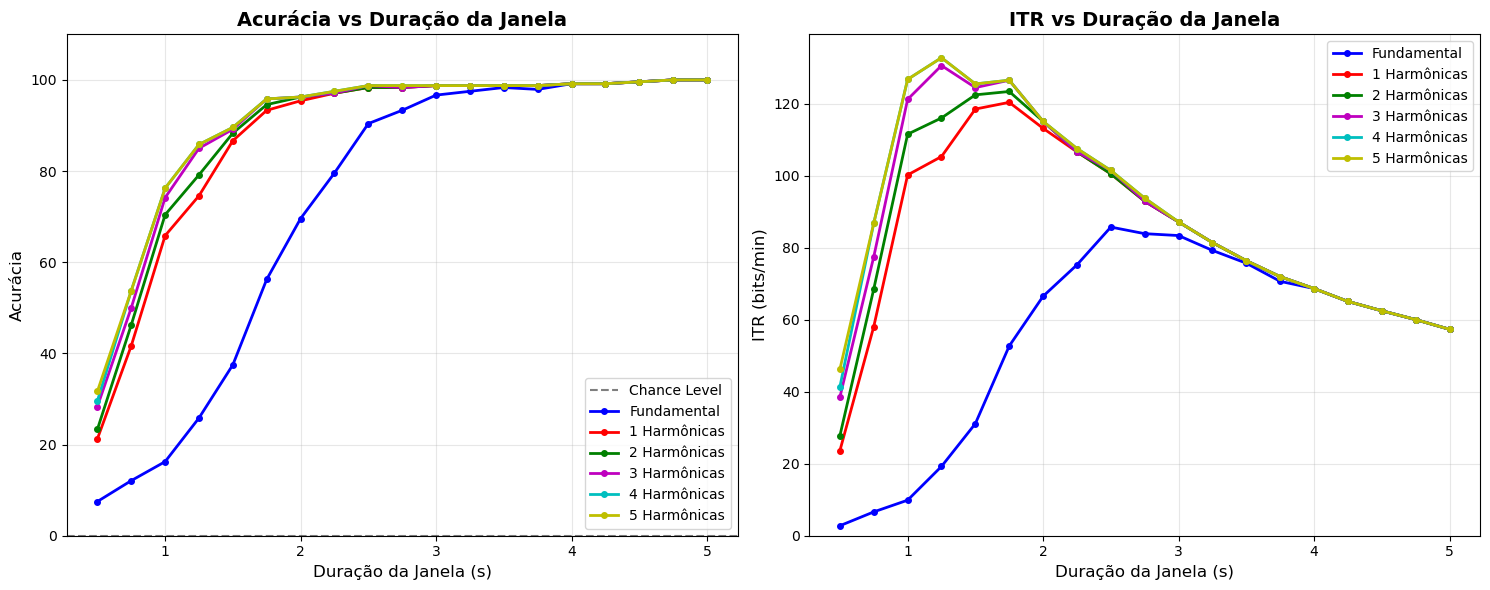

In [54]:
resultados = calcular_acuracia_itr(duracoes, harmonicas_configs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cores = ['b-', 'r-', 'g-', 'm-', 'c-', 'y-']
#cores = ['b-', 'r-']
labels = ['Fundamental', '1 Harmônicas', '2 Harmônicas', '3 Harmônicas', '4 Harmônicas', '5 Harmônicas']

ax1.set_title('Acurácia vs Duração da Janela', fontsize=14, fontweight='bold')
ax1.set_xlabel('Duração da Janela (s)', fontsize=12)
ax1.set_ylabel('Acurácia', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1/num_classes, color='k', linestyle='--', alpha=0.5, label='Chance Level')

for i, num_harmonicas in enumerate(harmonicas_configs):
    ax1.plot(duracoes, resultados[num_harmonicas]['acuracias'], 
             cores[i], linewidth=2, marker='o', markersize=4, label=labels[i])

ax1.legend()
ax1.set_ylim(0, 110)

ax2.set_title('ITR vs Duração da Janela', fontsize=14, fontweight='bold')
ax2.set_xlabel('Duração da Janela (s)', fontsize=12)
ax2.set_ylabel('ITR (bits/min)', fontsize=12)
ax2.grid(True, alpha=0.3)

for i, num_harmonicas in enumerate(harmonicas_configs):
    ax2.plot(duracoes, resultados[num_harmonicas]['itrs'], 
             cores[i], linewidth=2, marker='o', markersize=4, label=labels[i])

ax2.legend()
ax2.set_ylim(0, None)

plt.tight_layout()
plt.show()